## Контекст
Чем активнее пользователи, тем выше нагрузка на серверы. В последнее время участились жалобы на «подвисания» приложения. Нужно спрогнозировать, как изменится активность пользователей в ближайший период, чтобы помочь девопсам и инженерам планировать мощности.

## Цель
Построить и валидировать прогноз пользовательской активности на горизонте ближайшего месяца (с честными ограничениями по данным), выбрать лучшую модель и интерпретировать результаты с точки зрения нагрузки на сервер.

## Что сделаем в этой тетрадке
1. **Выбор метрики и частоты данных**
   - Определим основную метрику для прогноза и обоснуем выбор.
   - Выберем временное разрешение (час/день) и объясним, почему именно оно.
   - Опишем возможные дополнительные регрессоры (и условия их использования в прогнозе).

2. **Построение моделей и валидация**
   - Соберём ряд из БД и подготовим датасет.
   - Построим модели (Seasonal-Naive, KTRLite, DLT(+регрессор), CatBoost).
   - Проведём валидацию и сравнение моделей.
   - Ответим, хватает ли данных для **бэктестинга под текущую задачу** (месячный горизонт) и **для какого горизонта** данных точно достаточно (например, 7 дней при ~1 месяце истории).

3. **Выбор лучшей модели и интерпретация**
   - Выберем модель-победителя по согласованным метрикам качества (WMAPE/sMAPE/MAE на едином holdout).
   - Интерпретируем компоненты (тренд/сезонности/вклад регрессоров).
   - Укажем важные ограничения и оговорки (например, надёжность месячного прогноза при короткой истории).

4. **Бонус**
   - Коротко опишем удобство использования **Orbit**.
   - Сравним Orbit с альтернативами (Prophet, Darts и др.) по важным для нас признакам.

## Выходные артефакты
- Прогноз активности на ближайший период (с доверительными интервалами).
- Сводная таблица точностей по моделям на едином окне валидации.
- Финальный выбор модели и рекомендации по эксплуатации прогноза (горизонт, частота обновления, риски).

### 1. Загрузка данных и выбор метрики

In [170]:
#импорт библиотек
import pandas as pd
import numpy as np
import clickhouse_connect
from orbit.models import KTRLite, DLT
from orbit.diagnostics.plot import plot_predicted_data
from catboost import CatBoostRegressor

In [131]:
#подключение к clickhouse
conn = clickhouse_connect.get_client(
    host='clickhouse.lab.karpov.courses', port=443,
    username='student', password='dpo_python_2020',
    database='simulator', secure=True
)

In [132]:
#запрос на получение данных
q = """
SELECT
  toStartOfHour(time) AS hour_time,
  count()            AS events_per_hour,         
  uniqExact(user_id) AS active_users_per_hour    
FROM simulator_20250820.feed_actions

GROUP BY hour_time
ORDER BY hour_time
"""

In [133]:
#сохраняем данные
df = conn.query_df(q)
df.head()

,hour_time,events_per_hour,active_users_per_hour
0,2025-07-06 00:00:00+03:00,22,14
1,2025-07-06 01:00:00+03:00,32,26
2,2025-07-06 02:00:00+03:00,24,16
3,2025-07-06 03:00:00+03:00,11,11
4,2025-07-06 04:00:00+03:00,18,14


In [134]:
#общая информация
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1840 entries, 0 to 1839
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype                       
---  ------                 --------------  -----                       
 0   hour_time              1840 non-null   datetime64[s, Europe/Moscow]
 1   events_per_hour        1840 non-null   uint64                      
 2   active_users_per_hour  1840 non-null   uint64                      
dtypes: datetime64[s, Europe/Moscow](1), uint64(2)
memory usage: 43.3 KB


In [135]:
#чиним время
df['hour_time'] = pd.to_datetime(df['hour_time'])
if isinstance(df['hour_time'].dtype, pd.DatetimeTZDtype):
    df['hour_time'] = df['hour_time'].dt.tz_convert('UTC').dt.tz_localize(None)

In [136]:
#описательные статистики
df.describe()

,hour_time,events_per_hour,active_users_per_hour
count,1840,1840.000000,1840.000000
mean,2025-08-13 04:30:00,26727.386957,1316.344022
min,2025-07-05 21:00:00,11.000000,11.000000
25%,2025-07-25 00:45:00,15314.500000,751.500000
50%,2025-08-13 04:30:00,24906.500000,1297.000000
75%,2025-09-01 08:15:00,35052.500000,1862.250000
max,2025-09-20 12:00:00,95649.000000,3053.000000
std,NaN,15468.318252,657.640693


In [137]:
activity = (df.set_index('hour_time')
              .reindex(full, fill_value=0)
              .rename_axis('hour_time')
              .reset_index()
              .sort_values('hour_time'))

### Вывод: 
- **Объём истории:** ~1840 часов ≈ **76 дней** (порядка 10–11 недельных циклов).  
- **Вариабельность:** CV(events) ≈ 0.58; CV(AAU) ≈ 0.50 — заметные колебания.  
- **Пики:** `events_per_hour` до **~96k** (≈ 2.7× выше Q3) — есть «тяжёлые» часы, где риск подвисаний максимален.  
- **Смещённость:** медиана < среднего → слабая правосторонняя асимметрия (хвост из пиков).  
- **Вывод для моделирования:** выраженные суточная/недельная сезонности + «пиковые» часы → целесообразен **часовой шаг** и модели, умеющие ловить множественную сезонность/нелинейности.

- **Метрика:** `events_per_hour` — число событий/запросов в час. Это прямой прокси нагрузки (каждое событие = запрос к бэкенду), поэтому лучше коррелирует с подвисаниями, чем доли/отношения (например, CTR).  
- **Параллельно:** `active_users_per_hour (AAU)` — sanity-check и потенциальный регрессор/прокси спроса.  
- **Шаг:** **час** — явно ловит суточную (24) и недельную (168) сезонности.  
- **Регрессоры:** в минимальном решении не используем. Для усиления — только те, чьи будущие значения **известны** (праздники/выходные, заранее планируемые кампании) либо отдельный прогноз другого ряда (как **AAU → DLT**).


### 2. Построение и валидация. Достаточность данных

In [138]:
#выделяем holdout-окно для одинаковой оценки всех моделей (последние 7 дней)
H = 24 * 7
train_df = activity.iloc[:-H].copy()
test_df  = activity.iloc[-H:].copy()


Определим общие метрики точности

In [139]:
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    denom = np.abs(y_true) + np.abs(y_pred)
    denom[denom == 0] = 1.0
    return float(np.mean(2.0 * np.abs(y_pred - y_true) / denom))

In [140]:
def wmape(y_true, y_pred, eps=1.0):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    denom = np.abs(y_true).sum()
    if denom < eps: denom = eps
    return float(np.abs(y_pred - y_true).sum() / denom)

In [141]:
def mae(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    return float(np.mean(np.abs(y_pred - y_true)))

In [142]:
def mse(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    return float(np.mean((y_pred - y_true) ** 2))

**Модель 1 - Бейзлайн Seasonal-Naive прогноз — значение этого же часа неделей раньше**

In [143]:
naive_pred = activity['events_per_hour'].shift(24*7).iloc[-H:].to_numpy()
naive_true = test_df['events_per_hour'].to_numpy()


In [144]:
scores_naive = {
    'Model': 'Seasonal-Naive (-7d)',
    'SMAPE': smape(naive_true, naive_pred),
    'WMAPE': wmape(naive_true, naive_pred),
    'MAE':   mae(naive_true, naive_pred),
    'MSE':   mse(naive_true, naive_pred),
     
}

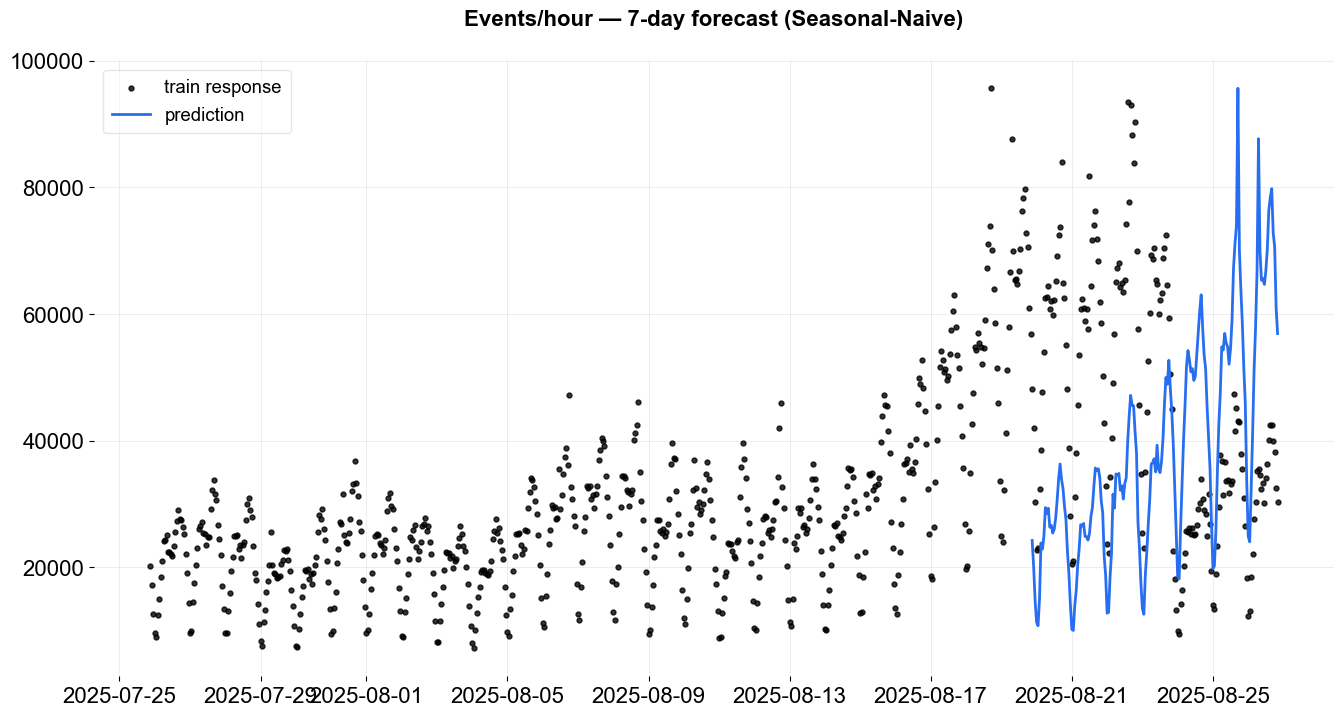

In [174]:
naive_future = pd.DataFrame({
    'hour_time': test_df['hour_time'].to_numpy(),
    'prediction': naive_pred
})
_ = plot_predicted_data(
    activity[['hour_time', 'events_per_hour']],
    naive_future,
    'hour_time', 'events_per_hour',
    title='Events/hour — 7-day forecast (Seasonal-Naive)'
)

**Модель 2 - KTRLite**

In [145]:
def ktr_holdout_and_future(train, full, target_col, horizon=H):
    # --- holdout: учимся на train, предсказываем test-окно (ровно horizon часов)
    ktr = KTRLite(response_col=target_col, date_col='hour_time',
                  seasonality=[24, 168], estimator='stan-map',
                  n_bootstrap_draws=1000, seed=2025)
    ktr.fit(train[['hour_time', target_col]])
    future_holdout = ktr.make_future_df(periods=horizon)         # ровно следующее окно
    pred_holdout   = ktr.predict(df=future_holdout)[['hour_time','prediction']]

    # --- future: переобучаемся на всех доступных данных и делаем прогноз ещё на horizon
    ktr_full = KTRLite(response_col=target_col, date_col='hour_time',
                       seasonality=[24, 168], estimator='stan-map',
                       n_bootstrap_draws=1000, seed=2025)
    ktr_full.fit(full[['hour_time', target_col]])
    future_next = ktr_full.make_future_df(periods=horizon)
    pred_future = ktr_full.predict(df=future_next)[['hour_time','prediction']]

    return pred_holdout, pred_future

In [146]:
pred_ktr_hold, pred_ktr_future = ktr_holdout_and_future(train_df, activity, 'events_per_hour', H)

2025-09-20 15:36:45 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
2025-09-20 15:36:45 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.


In [147]:
ktr_true = test_df['events_per_hour'].to_numpy()
ktr_pred = pred_ktr_hold['prediction'].to_numpy()

In [148]:
scores_ktr = {
    'Model': 'KTRLite',
    'SMAPE': smape(ktr_true, ktr_pred),
    'WMAPE': wmape(ktr_true, ktr_pred),
    'MAE':   mae(ktr_true, ktr_pred),
    'MSE':   mse(ktr_true, ktr_pred),
   
}

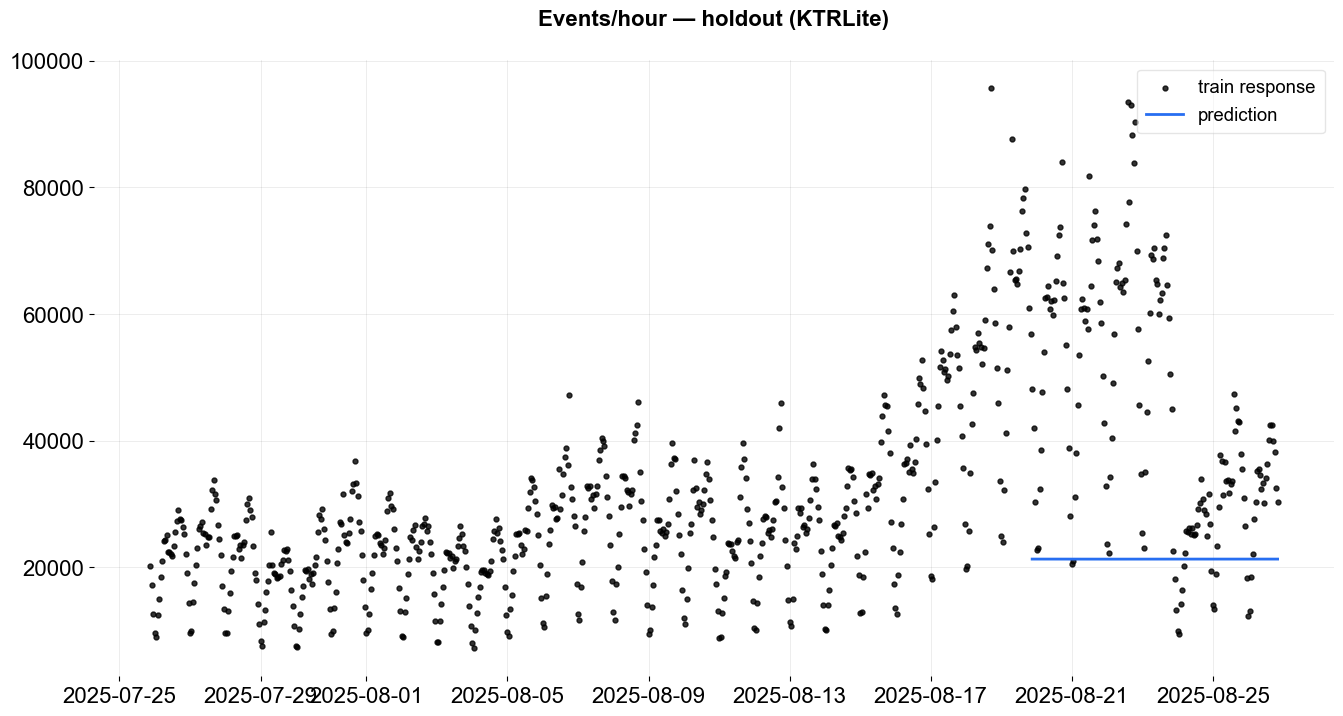

In [177]:
# Holdout (прогноз на тест-окно сразу после train)
_ = plot_predicted_data(
    activity[['hour_time', 'events_per_hour']],
    pred_ktr_hold,
    'hour_time', 'events_per_hour',
    title='Events/hour — holdout (KTRLite)'
)
plt.show()

**Модель 3 - DLT + AAU регрессор**

In [149]:
def dlt_with_aau_holdout_and_future(train, full, horizon=H):
    # --- (1) AAU → прогноз на holdout
    ktr_aau = KTRLite(response_col='active_users_per_hour', date_col='hour_time',
                      seasonality=[24,168], estimator='stan-map',
                      n_bootstrap_draws=1000, seed=2025)
    ktr_aau.fit(train[['hour_time','active_users_per_hour']])
    aau_hold = ktr_aau.predict(df=ktr_aau.make_future_df(periods=horizon))\
                      [['hour_time','prediction']].rename(columns={'prediction':'active_users_per_hour'})

    # --- (2) DLT (events ~ AAU), прогноз holdout с регрессором из (1)
    dlt = DLT(response_col='events_per_hour', date_col='hour_time',
              seasonality=24, estimator='stan-map',
              regressor_col=['active_users_per_hour'],
              n_bootstrap_draws=1000, seed=2025,
              global_trend_option='linear', damped_factor=0.8)
    dlt.fit(train[['hour_time','events_per_hour','active_users_per_hour']])

    future_hold = dlt.make_future_df(periods=horizon)
    future_hold = future_hold.merge(aau_hold, on='hour_time', how='left').ffill().bfill()
    pred_hold   = dlt.predict(df=future_hold)[['hour_time','prediction']]

    # --- (3) Future (на следующую неделю после full): снова AAU → DLT
    ktr_aau_full = KTRLite(response_col='active_users_per_hour', date_col='hour_time',
                           seasonality=[24,168], estimator='stan-map',
                           n_bootstrap_draws=1000, seed=2025)
    ktr_aau_full.fit(full[['hour_time','active_users_per_hour']])
    aau_next = ktr_aau_full.predict(df=ktr_aau_full.make_future_df(periods=horizon))\
                           [['hour_time','prediction']].rename(columns={'prediction':'active_users_per_hour'})

    dlt_full = DLT(response_col='events_per_hour', date_col='hour_time',
                   seasonality=24, estimator='stan-map',
                   regressor_col=['active_users_per_hour'],
                   n_bootstrap_draws=1000, seed=2025,
                   global_trend_option='linear', damped_factor=0.8)
    dlt_full.fit(full[['hour_time','events_per_hour','active_users_per_hour']])

    future_next = dlt_full.make_future_df(periods=horizon)
    future_next = future_next.merge(aau_next, on='hour_time', how='left').ffill().bfill()
    pred_next   = dlt_full.predict(df=future_next)[['hour_time','prediction']]

    return pred_hold, pred_next

In [150]:
pred_dlt_hold, pred_dlt_future = dlt_with_aau_holdout_and_future(train_df, activity, H)

2025-09-20 15:36:47 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
2025-09-20 15:36:47 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
2025-09-20 15:36:47 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
2025-09-20 15:36:47 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.


In [151]:
dlt_true = test_df['events_per_hour'].to_numpy()
dlt_pred = pred_dlt_hold['prediction'].to_numpy()

In [152]:
scores_dlt = {
    'Model': 'DLT (+AAU)',
    'SMAPE': smape(dlt_true, dlt_pred),
    'WMAPE': wmape(dlt_true, dlt_pred),
    'MAE':   mae(dlt_true, dlt_pred),
    'MSE':   mse(dlt_true, dlt_pred),
    
}

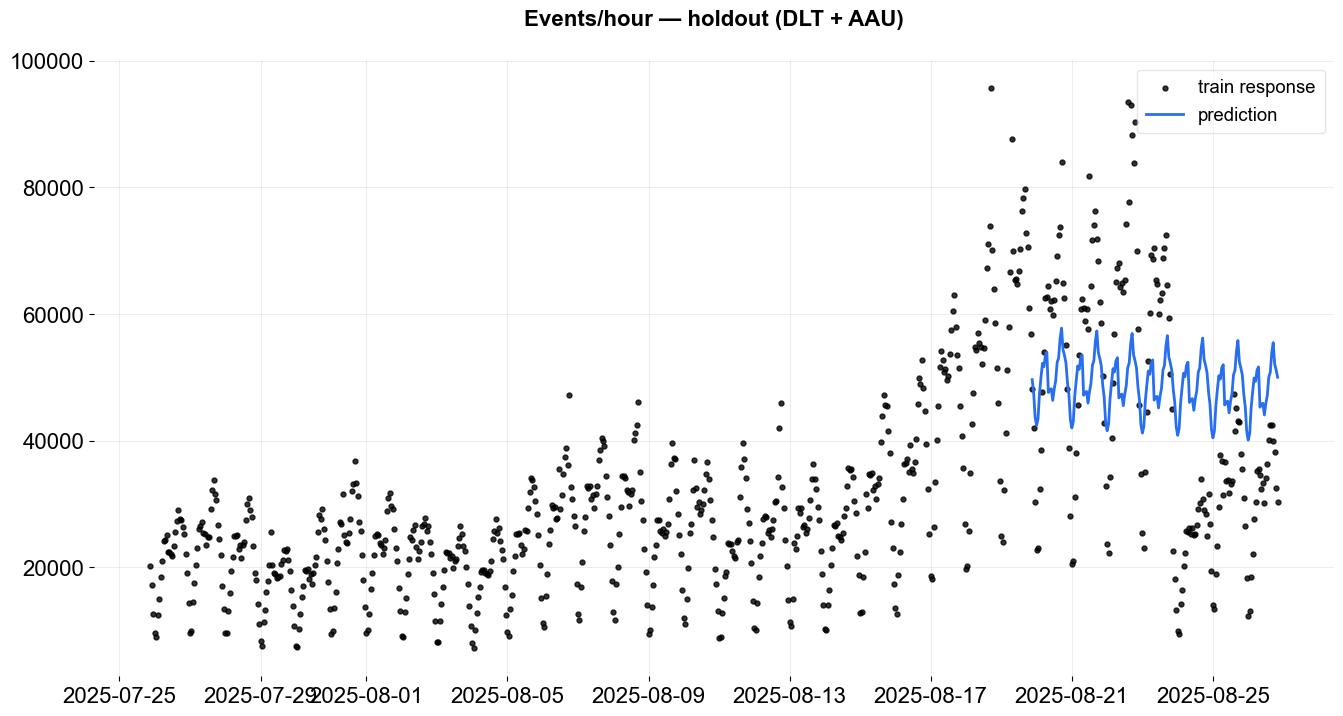

In [178]:
_ = plot_predicted_data(
    activity[['hour_time','events_per_hour']],
    pred_dlt_hold,
    'hour_time','events_per_hour',
    title='Events/hour — holdout (DLT + AAU)'
)

**Модель 4 - CatBoost**

In [153]:
def make_cat_features(df):
    d = df.copy()
    d['hour'] = d['hour_time'].dt.hour
    d['dow']  = d['hour_time'].dt.dayofweek
    for L in [1, 24, 168]:
        d[f'lag_{L}'] = d['events_per_hour'].shift(L)
    for W in [24, 168]:
        d[f'rollmean_{W}'] = d['events_per_hour'].shift(1).rolling(W).mean()
    return d.dropna()

In [154]:
# holdout для CatBoost: строим фичи и делим по последним H строкам
feats = make_cat_features(activity[['hour_time','events_per_hour']])
feats_train, feats_test = feats.iloc[:-H], feats.iloc[-H:]
X_tr = feats_train.drop(columns=['events_per_hour','hour_time'])
y_tr = feats_train['events_per_hour']
X_te = feats_test.drop(columns=['events_per_hour','hour_time'])
y_te = feats_test['events_per_hour']


In [155]:
cat = CatBoostRegressor(
    loss_function='RMSE', depth=8, learning_rate=0.05, iterations=1000,
    od_type='Iter', od_wait=50, random_seed=2025, verbose=False
)

In [156]:
cat.fit(X_tr, y_tr, eval_set=(X_te, y_te), use_best_model=True)

In [157]:
# holdout-предсказания CatBoost
cat_pred_hold = cat.predict(X_te)

In [158]:
scores_cat = {
    'Model': 'CatBoost (7d holdout)',
    'SMAPE': smape(y_te, cat_pred_hold),
    'WMAPE': wmape(y_te, cat_pred_hold),
    'MAE':   mae(y_te, cat_pred_hold),
    'MSE':   mse(y_te, cat_pred_hold),
}

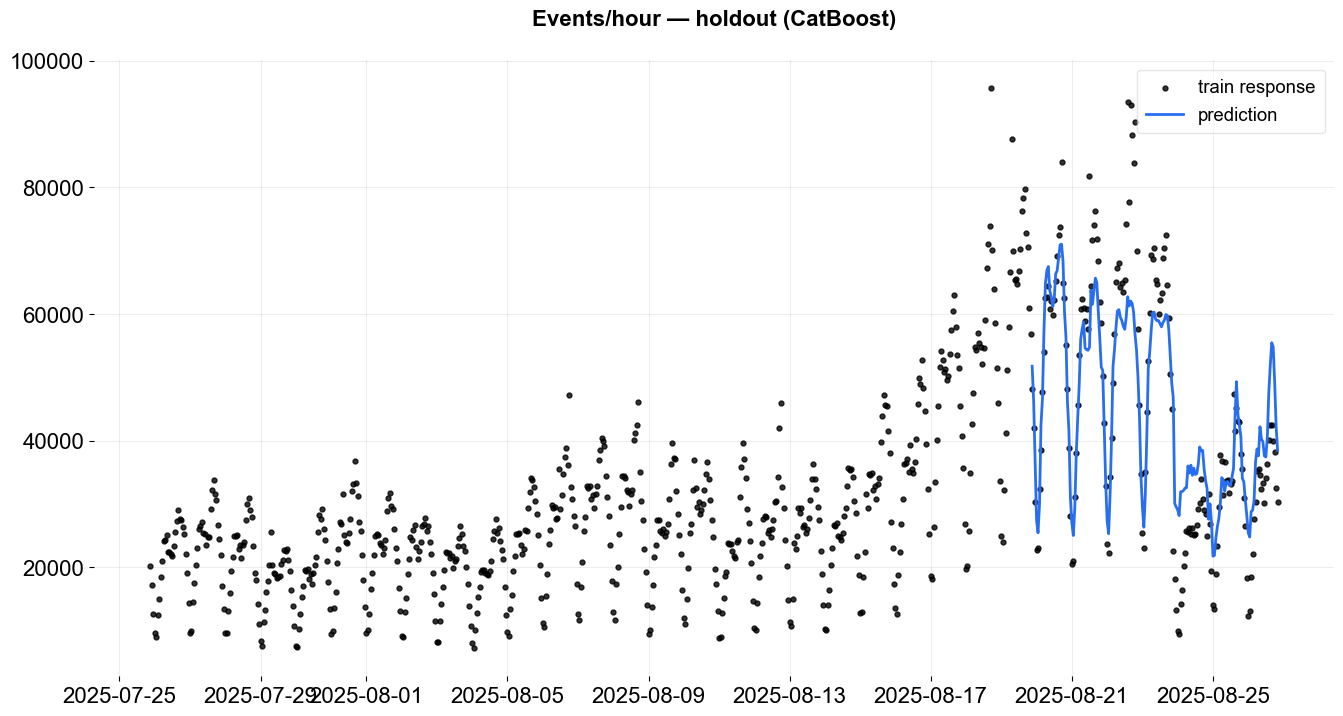

In [180]:
cat_hold_df = pd.DataFrame({
    'hour_time': feats_test['hour_time'].to_numpy(),
    'prediction': cat_pred_hold
})
_ = plot_predicted_data(
    activity[['hour_time','events_per_hour']],
    cat_hold_df,
    'hour_time','events_per_hour',
    title='Events/hour — holdout (CatBoost)'
)

In [159]:
#future-прогноз CatBoost
def cat_recursive_forecast(model, history_series, horizon=H):
    preds = []
    hist = history_series.copy()
    future_idx = pd.date_range(history_series.index.max() + pd.Timedelta(hours=1), periods=horizon, freq='H')
    for t in future_idx:
        row = {
            'hour': t.hour,
            'dow':  t.dayofweek,
            'lag_1':   hist.iloc[-1],
            'lag_24':  hist.iloc[-24],
            'lag_168': hist.iloc[-168],
            'rollmean_24':  hist.iloc[-24:].mean(),
            'rollmean_168': hist.iloc[-168:].mean(),
        }
        x = pd.DataFrame([row])
        yhat = model.predict(x).ravel()[0]  # извлекаем скаляр корректно
        preds.append(yhat)
        hist.loc[t] = yhat
    return pd.DataFrame({'hour_time': future_idx, 'prediction': preds})

In [160]:
pred_cat_future = cat_recursive_forecast(
    model=cat, history_series=activity.set_index('hour_time')['events_per_hour'], horizon=H
)

/var/folders/9p/7lld845n4hs8rp09pw3p8vfc0000gn/T/ipykernel_33775/940742771.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_idx = pd.date_range(history_series.index.max() + pd.Timedelta(hours=1), periods=horizon, freq='H')


In [165]:
#сводная таблица точности
summary = pd.DataFrame([scores_naive, scores_ktr, scores_dlt, scores_cat]).set_index('Model')
summary = summary.round({'SMAPE': 4, 'WMAPE': 4, 'MAE': 1, 'MSE': 0})
display(summary.sort_values('WMAPE'))  # или print(...)



,SMAPE,WMAPE,MAE,MSE
Model,,,,
CatBoost (7d holdout),0.1749,0.1511,6772.1,83556611.0
DLT (+AAU),0.3879,0.3673,16458.3,337468764.0
KTRLite,0.6456,0.5489,24592.1,951109652.0
Seasonal-Naive (-7d),0.6142,0.5751,25768.1,778422455.0


### Вывод
**Подход к валидации:**
- История в текущей выгрузке ≈ **76 дней** — этого достаточно, чтобы увидеть многократные недельные циклы и провести честный **holdout на 7 дней** (а также expanding-бэктест, при желании).  
- Для сравнения моделей используем **единый holdout 7 дней (168 часов)** и метрики **WMAPE (базовая), sMAPE, MAE, MSE**.  
- **Сильный бейзлайн:** **Seasonal-Naive (−7 дней)** — значение того же часа неделей ранее.

**Практический результат:**
- На едином holdout **CatBoost** дал лучшую точность (WMAPE), затем **DLT(+AAU)**, далее, **KTRLite**, **Seasonal-Naive**— слабее на коротком горизонте.


Данных для прогнозирования на месяц не достаточно,но, данных достаточно для корректной валидации. Надёжный эксплуатационный горизонт — **7 дней** (даже при 76 днях истории), т.к. пиковая вариабельность высока и внешние факторы не моделированы явным регрессором. Месячный прогноз возможен как эксперимент с широкими интервалами, но для SLA лучше использовать недельный с регулярным обновлением.

---

### 3. Выбор модели, интерпретация и ограничения

Финальный прогноз лучшей модели + график

In [166]:
#выбираем модель с минимальным WMAPE 
best_model = summary['WMAPE'].idxmin()
print(f'Chosen model on 7d holdout: {best_model}')

Chosen model on 7d holdout: CatBoost (7d holdout)


In [167]:
if best_model == 'KTRLite':
    final_future = pred_ktr_future
elif best_model == 'DLT (+AAU)':
    final_future = pred_dlt_future
elif best_model == 'CatBoost (7d holdout)':
    final_future = pred_cat_future
else:  
    base = activity.set_index('hour_time')['events_per_hour']
    future_idx = pd.date_range(activity['hour_time'].max() + pd.Timedelta(hours=1), periods=H, freq='H')
    final_future = pd.DataFrame({
        'hour_time': future_idx,
        'prediction': base.iloc[-H:].to_numpy()
    })

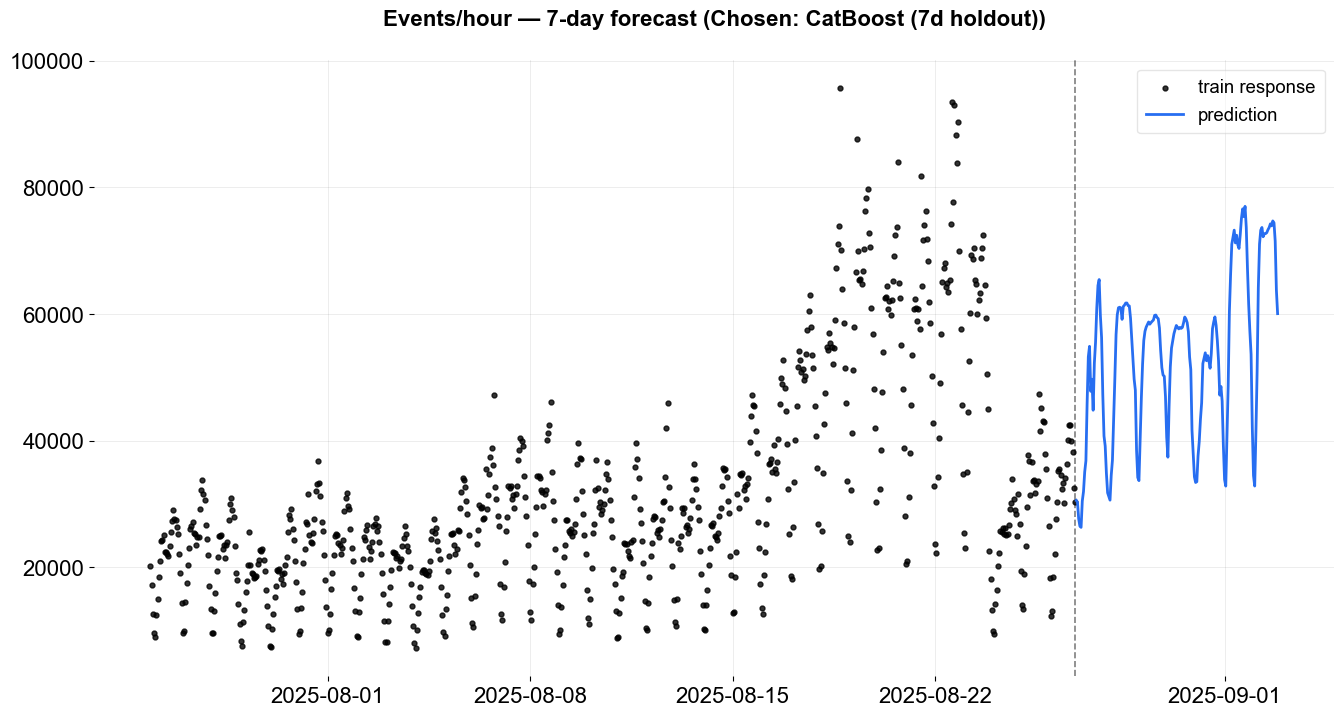

In [168]:
#рисуем финальный недельный прогноз
_ = plot_predicted_data(activity[['hour_time','events_per_hour']], final_future,
                        'hour_time', 'events_per_hour',
                        title=f'Events/hour — 7-day forecast (Chosen: {best_model})')

**Сравниваемые подходы:**
- **Seasonal-Naive (−7д):** прозрачный и сильный базовый ориентир.  
- **KTRLite [24,168]:** ловит суточную и недельную сезонности; интерпретируемые компоненты.  
- **DLT + AAU:** добавляем регрессор `AAU`; приглушаем тренд; недельную сезонность DLT не моделирует напрямую, но AAU частично её «объясняет».  
- **CatBoost:** ML-подход с лагами/роллингами (1/24/168) и календарём; часто выигрывает на коротком горизонте за счёт нелинейностей.

**Выбор:**  
По единому holdout (7 дней) — **берём модель с минимальным WMAPE**. В нашем случае лидирует **CatBoost**; дальше — **DLT(+AAU)**.

**Интерпретация:**
- **Сезонности:** выраженные суточная и недельная (вечерние пики, провалы ночью/в выходные).  
- **Связь с AAU:** в DLT вклад AAU положителен — рост активных пользователей «тянет» нагрузку.  
- **Тренд:** на месячном горизонте идентифицируется слабо; полагаемся на сезонности и уровни; публикуем прогноз **с интервалами**.

**Ограничения и рекомендации:**
- **Короткий эксплуатационный горизонт:** используем **7-дневный** прогноз, **перерасчёт каждые 1–3 дня** (скользящее окно 28–35 дней).  
- **Регрессоры** — только при известных будущих значениях (либо отдельный прогноз/сценарии).  
- **Аномалии** (релизы/инциденты) — помечать дамми/исключать из обучения.  
- **Метрики:** ориентируемся на **WMAPE/sMAPE/MAE**; RMSSE — опционально как относительное улучшение над наивным.

## Общий вывод

- **Что прогнозируем:** основная метрика — `events_per_hour` (прямой прокси нагрузки). Параллельно считаем `active_users_per_hour (AAU)` как контроль и возможный регрессор.
- **Шаг и сезонности:** часовой шаг позволяет учесть суточную (24) и недельную (168) сезонности, которые и формируют пики/провалы нагрузки.
- **Данные:** в выгрузке ~76 дней (≈1840 часов). Этого достаточно для честной недельной валидации и прогноза, но **недостаточно для уверенного месячного горизонта** без сильных оговорок.
- **Валидация:** единый holdout 7 дней (168 часов) и сравнение по WMAPE/sMAPE/MAE/MSE с сильным бэйзлайном **Seasonal-Naive (−7д)**.
- **Модели и выбор:** 
  - **CatBoost** (лаги/роллинги 1/24/168) показал наилучший WMAPE на holdout — **основной рабочий прогноз на неделю**.
  - **DLT + AAU** — второй по точности, удобен для учёта влияния активной аудитории.
  - **KTRLite [24,168]** — интерпретируемый референс (компоненты сезонностей), но на коротком горизонте уступает.
  - **Seasonal-Naive** — сильный ориентир; держим как fallback.
- **Ограничения:** месячный прогноз на текущей истории ненадёжен; аномалии/релизы требуют дамми/фильтрации; регрессоры допустимы только при известных будущих значениях (или их отдельном прогнозе).
- **Рекомендации по эксплуатации:**
  1. Публиковать **7-дневный** прогноз с **перерасчётом каждые 1–3 дня** (скользящее окно 28–35 дней).
  2. Мониторить качество (WMAPE/sMAPE/MAE) и дрейф; при деградации — временно переключаться на Seasonal-Naive.
  3. Расширять историю и добавлять «знания о будущем» (праздники, релизы, кампании) как регрессоры; прогнозировать AAU для DLT.
  4. Использовать интервалы прогноза для принятия решений по масштабированию (e.g. планирование капасити на верхний перцентиль).
  
**Итог:** для оперативного планирования ресурсов на ближайшую неделю используем **CatBoost** как модель-победитель по точности; **DLT(+AAU)** и **KTRLite** оставляем для объяснимости и контроля. Горизонт — **7 дней**, с регулярным обновлением и мониторингом качества.

**Бонус: Orbit vs CatBoost**  
- **Orbit** — интерпретируемые TS-модели (KTR/DLT): дают тренд/сезонности/вклад регрессоров и интервальные прогнозы «из коробки», удобный встроенный бэктест.  
- **CatBoost** — бустинг с фичеинжинирингом (лаги/роллинги/календарь): часто **точнее на коротком горизонте (1–7 дней)** и гибок при нелинейностях, но менее прозрачен.  
- Сезонности: в **Orbit/KTR** множественные (24/168) моделируются нативно; в **CatBoost** их нужно сделать руками через признаки.  
- Интервалы: **Orbit** — байесовские/бутстрэп-интервалы; **CatBoost** — через квантильные модели (нужны отдельные модели для 5%/95%).  
- Валидация: **Orbit** имеет BackTester; для **CatBoost** holdout/rolling-CV настраиваем сами.  
- Когда выбирать: **Orbit** — для объяснимости, сценариев и средне-долгого горизонта; **CatBoost** — для максимальной краткосрочной точности при готовности к фичеинжинирингу.  
- Практика: сочетать — **точку** брать из CatBoost, **интервалы/компоненты** и sanity-чек из Orbit; на релизные недели планировать капасити по верхнему перцентилю из Orbit.